<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_04%5DTry_changing_the_Vocabulary_Size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_04]Try changing the Vocabulary Size

지금까지는 모델을 변경하고, 모델을 조합해서 성능을 올리는 일에 힘썼습니다. 그런데 어쩌면 성능을 높이는 방법은 단순히 모델을 조정하는 일에 한정되지 않을 수 있습니다. 데이터의 전처리는 모델의 성능에 영향을 직접적으로 줍니다. 특히나 Bag of Words를 기반으로 하는 DTM이나 TF-IDF의 경우, 사용하는 단어의 수를 어떻게 결정하느냐에 따라서 성능에 영향을 줄 수 있겠죠.

중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우에도 성능이 저하될 수 있고, 반대로 너무 적은 단어들을 사용해도 성능이 저하될 수 있습니다. 이렇게 변화된 단어의 수는 또 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있습니다.

> 따라서 단어의 수에 따라 모델의 성능이 어떻게 변하는지 테스트 해보겠습니다. 앞서 num_words로 사용할 단어의 수를 조정할 수 있다는 것을 배웠습니다. 빈도수가 많은 순서대로 나열했을 때, num_words의 인자로 준 정숫값만큼의 단어를 사용하고 나머지 단어는 전부 <unk>로 처리하는 원리였었죠.

## 1. Import 및 데이터 로드

In [12]:
# 기본 import 
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 벡터화
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# sklearn Mldel import
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# 평가
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 딥러닝
import tensorflow as tf

## 2. 함수구현

### 1) data_load
- 데이터 불러오기
- 데이터 분석
- 데이터 텍스트로 변환
- 데이터 벡터화

In [17]:
def data_load(num_words, test_split=0.2):

  (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=test_split)

  if num_words == None:
    print('-'*25,'샘플수','-'*25)
    print('훈련 샘플의 수 : {}'.format(len(x_train)))
    print('테스트 샘플의 수 : {}'.format(len(x_test)))

    print()
    print('-'*25,'클래스의 수','-'*25)
    num_classes = max(y_train) + 1
    print('클래스의 수 : {}'.format(num_classes))

    print()
    print('-'*25,'길이','-'*25)
    print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
    print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

    print()
    print('-'*25,'데이터 분포','-'*25)
    plt.hist([len(s) for s in x_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    print()
    print('-'*25,'클래스 분포','-'*25)
    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    sns.countplot(x=y_train)
    plt.show()

  ## 데이터 텍스트로 처리
  word_index = reuters.get_word_index(path='reuters_word_index.json')
  index_to_word = {index+3 : word for word, index in word_index.items()}
  for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
    index_to_word[index]=token

  decoded = []
  for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

  x_train = decoded

  decoded = []
  for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

  x_test = decoded

  # 데이터 벡터화
  dtmvector = CountVectorizer()
  tfidf_transformer = TfidfTransformer()

  x_train_dtm = dtmvector.fit_transform(x_train)
  tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)

  x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
  tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

  return tfidfv_train, y_train, tfidfv_test, y_test


### 2) ML_Models

In [8]:
def ML_Models(tfidfv, y_train, tfidfv_test, y_test):
  # 다항분포 나이브 베이즈
  mnb = MultinomialNB()
  mnb.fit(tfidfv, y_train)
  predicted = mnb.predict(tfidfv_test) #테스트 데이터에 대한 예측
  print("다항분포 나이브 베이즈 정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

  # Complement Naive Bayes Classifier(CNB)
  cb = ComplementNB()
  cb.fit(tfidfv, y_train)
  predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
  cv_accuracy = accuracy_score(y_test, predicted)
  print("컴플리먼트 나이브 베이즈 정확도:", cv_accuracy) #예측값과 실제값 비교

  # 로지스틱 회귀 분석
  lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
  lr.fit(tfidfv, y_train)
  predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
  lr_accuracy = accuracy_score(y_test, predicted)
  print("로지스틱 회귀 정확도:", lr_accuracy) #예측값과 실제값 비교

  # 선형 서포트 벡터 머신
  lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
  lsvc.fit(tfidfv, y_train)
  predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
  lsvc_accuracy = accuracy_score(y_test, predicted)
  print("선형 서포트 벡터 머신 정확도:", lsvc_accuracy) #예측값과 실제값 비교

  # 결정 트리
  tree = DecisionTreeClassifier(max_depth=10, random_state=0)
  tree.fit(tfidfv, y_train)
  predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
  tree_accuracy = accuracy_score(y_test, predicted)
  print("결정 트리 정확도:", tree_accuracy) #예측값과 실제값 비교

  # 랜덤 포레스트
  forest = RandomForestClassifier(n_estimators=5, random_state=0)
  forest.fit(tfidfv, y_train)
  predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
  forest_accuracy = accuracy_score(y_test, predicted)
  print("랜덤 포레스트 정확도:", forest_accuracy) #예측값과 실제값 비교

  # 그레디언 부스트
  grbt = GradientBoostingClassifier(random_state=0) # verbose=3
  grbt.fit(tfidfv, y_train)
  predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
  grbt_accuracy = accuracy_score(y_test, predicted)
  print("그레디언 부스트 정확도:", grbt_accuracy) #예측값과 실제값 비교

  # 보팅
  voting_classifier = VotingClassifier(estimators=[
          ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
          ('cb', ComplementNB()),
          ('grbt', GradientBoostingClassifier(random_state=0))
  ], voting='soft')
  voting_classifier.fit(tfidfv, y_train)
  predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
  voting_accuracy = accuracy_score(y_test, predicted)
  print("보팅 정확도:", voting_accuracy) #예측값과 실제값 비교

  return mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier


### 3) F1-Score, Confusion Matrix


In [9]:

def fcm(models, tfidfv_test, y_test):
  for model in models:
    if model == mnb:
      model_name = 'Multinomial Naive Bayes Classifier'
    elif model == cb:
      model_name = 'Complement Naive Bayes Classifier'
    elif model == lr:
      model_name = 'Logistic Regression'
    elif model == lsvc:
      model_name = 'Linear Support Vector Machine'
    elif model == tree:
      model_name = 'Decision Tree'
    elif model == forest:
      model_name = 'Random Forest'
    elif model == grbt:
      model_name = 'GradientBoostingClassifier'
    else:
      model_name = 'Voting'
    
    print('-'*25,model_name,'-'*25)
    print()
    print("f1-score : ", classification_report(y_test, model.predict(tfidfv_test), zero_division=0))


    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(tfidfv_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('{} label'.format(model_name))
    plt.xlabel('{} predicted value'.format(model_name))



## 2. 모든 단어 사용

------------------------- 샘플수 -------------------------
훈련 샘플의 수 : 8982
테스트 샘플의 수 : 2246

------------------------- 클래스의 수 -------------------------
클래스의 수 : 46

------------------------- 길이 -------------------------
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633

------------------------- 데이터 분포 -------------------------


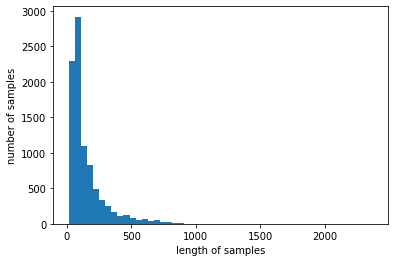


------------------------- 클래스 분포 -------------------------


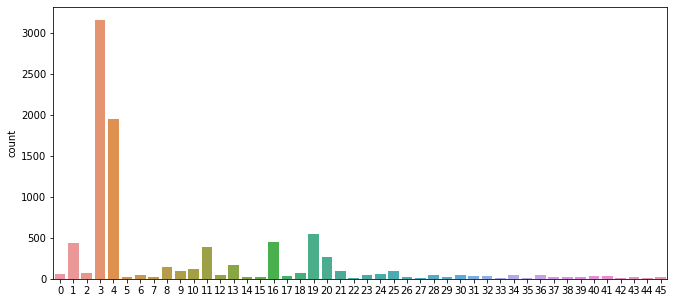

In [18]:
tfidfv_train, y_train, tfidfv_test, y_test = data_load(num_words=None, test_split=0.2)

In [6]:
mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier = ML_Models(tfidfv_train, y_train, tfidfv_test, y_test)

다항분포 나이브 베이즈 정확도: 0.5997328584149599
컴플리먼트 나이브 베이즈 정확도: 0.7649154051647373
로지스틱 회귀 정확도: 0.8170080142475512


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


선형 서포트 벡터 머신 정확도: 0.7920747996438112
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6544968833481746
그레디언 부스트 정확도: 0.7666963490650045
보팅 정확도: 0.815227070347284


------------------------- Multinomial Naive Bayes Classifier -------------------------

f1-score :                precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.79      0.21      0.33       105
           2       0.00      0.00      0.00        20
           3       0.72      0.92      0.81       813
           4       0.45      0.96      0.61       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00        25
          10       0.00      0.00      0.00        30
          11       0.80      0.29      0.42        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00  

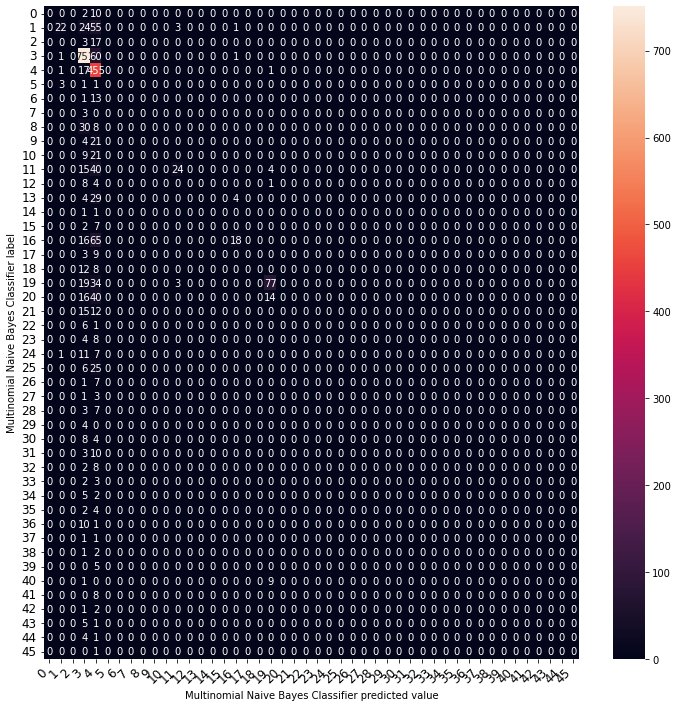

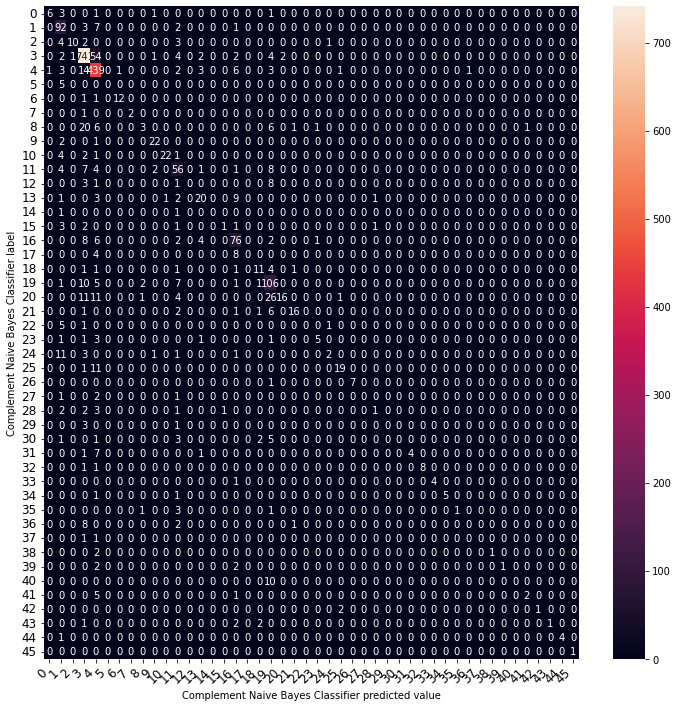

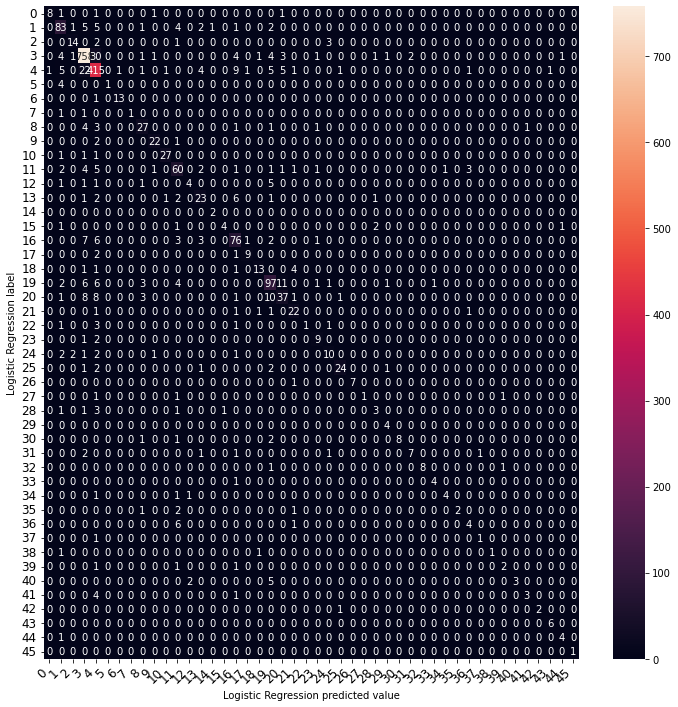

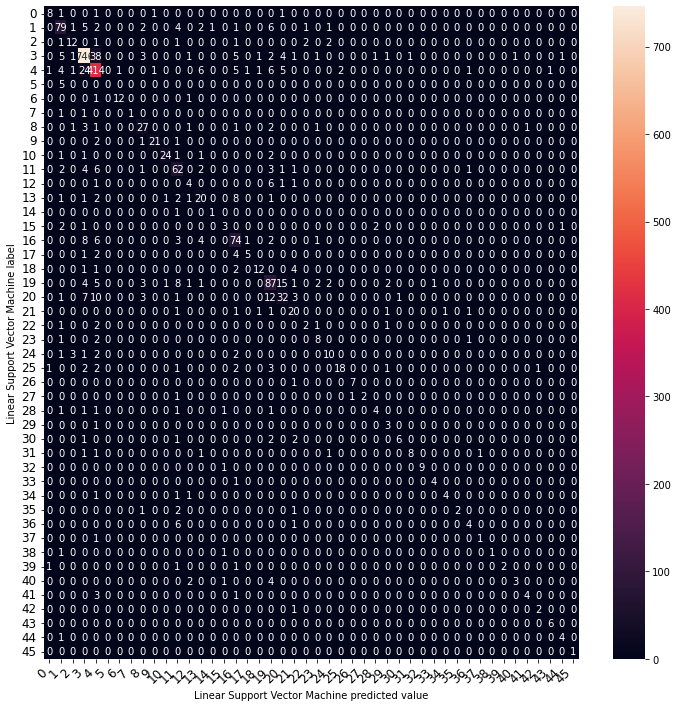

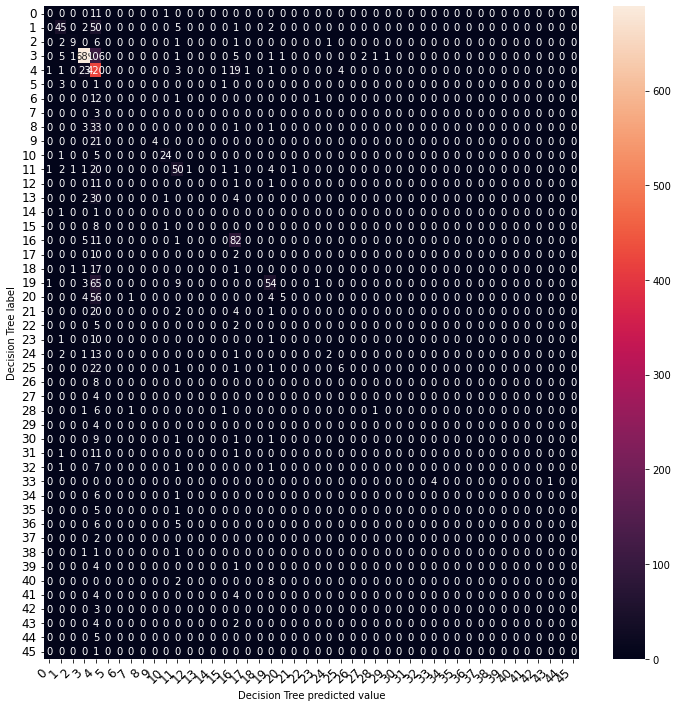

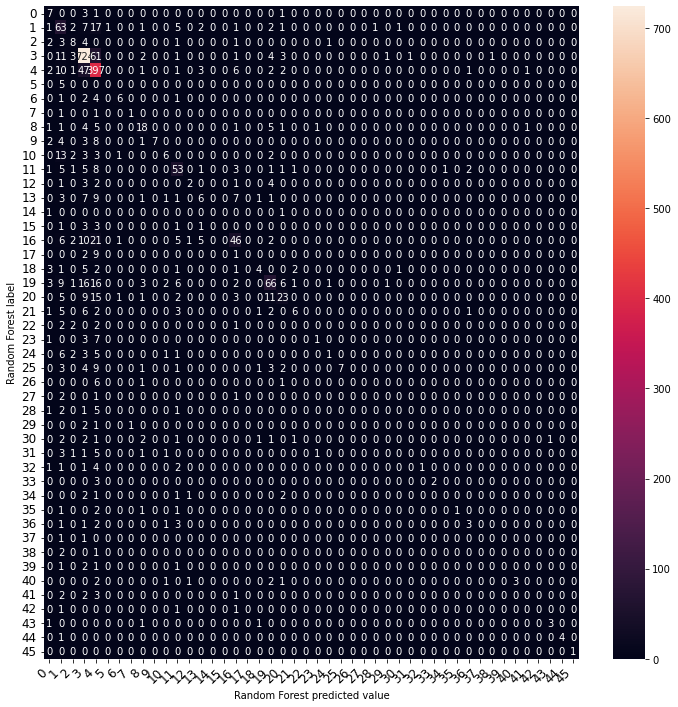

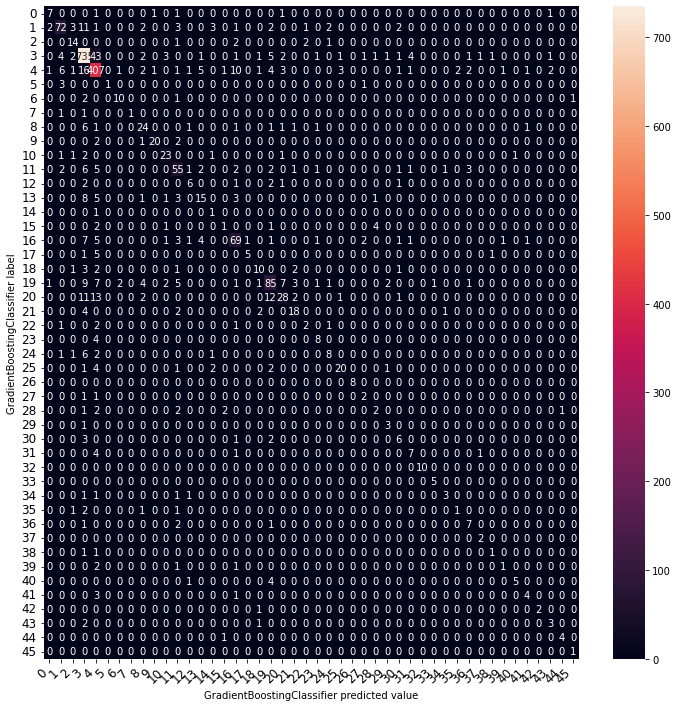

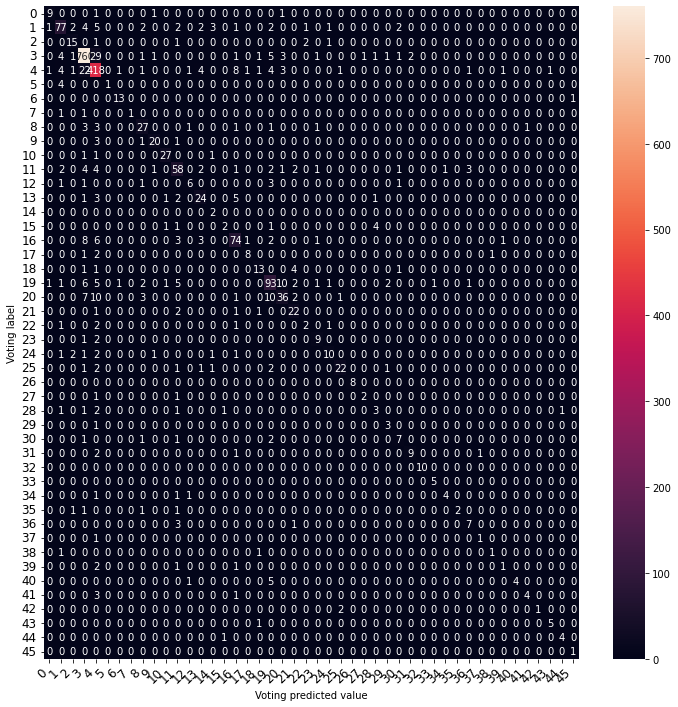

In [7]:
models = [mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]
fcm(models, tfidfv_test, y_test)

## 3. 빈도수 상위 5000개의 단어만 사용

In [19]:
tfidfv_train, y_train, tfidfv_test, y_test = data_load(num_words=5000, test_split=0.2)

In [5]:
mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier = ML_Models(tfidfv_train, y_train, tfidfv_test, y_test)

NameError: ignored

In [ ]:
models = [mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]
fcm(models, tfidfv_test, y_test)

## 4. 직접 단어 개수를 설정해서 사용

------------------------- 샘플수 -------------------------
훈련 샘플의 수 : 8982
테스트 샘플의 수 : 2246

------------------------- 클래스의 수 -------------------------
클래스의 수 : 46

------------------------- 길이 -------------------------
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633

------------------------- 데이터 분포 -------------------------


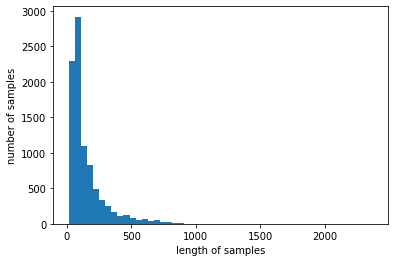


------------------------- 클래스 분포 -------------------------


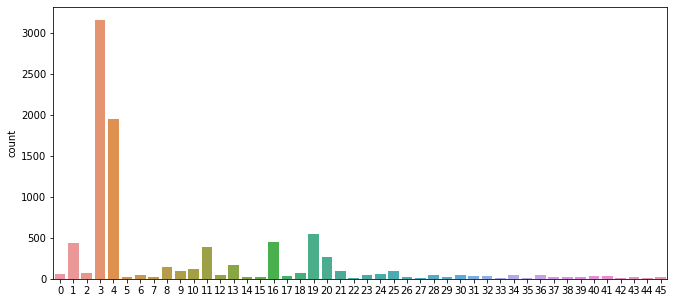

In [11]:
tfidfv_train, y_train, tfidfv_test, y_test = data_load(num_words=1000, test_split=0.2)

In [ ]:
mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier = ML_Models(tfidfv_train, y_train, tfidfv_test, y_test)

In [ ]:
models = [mnb, cb, lr, lsvc, tree, forest, grbt, voting_classifier]
fcm(models, tfidfv_test, y_test)

## 5. 딥러닝 모델과 비교하기

In [ ]:
vocab_size = 8000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 130  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(16, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

In [ ]:
# validation set 10000건 분리

tfidfv_val= round(len(tfidfv_train)*0,2)
x_val = tfidfv_train[:tfidfv_val]   
y_val = y_train[:tfidfv_val]

# validation set을 제외한 나머지 15000건
partial_x_train = tfidfv_train[tfidfv_val:]  
partial_y_train = y_train[tfidfv_val:]

print(partial_x_train.shape)
print(partial_y_train.shape)

In [ ]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

In [ ]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

# "bo"는 "파란색 점"입니다
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [ ]:
results = model_lstm.evaluate(tfidfv_test,  y_test, verbose=2)

print(results)

In [ ]:
fcm(model_lstm, tfidfv_test, y_test)

1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
  - 3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.

2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
  - Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.

3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?
  - 동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.